# Titanic

![Titanic](Titanic.png)

In [1]:
# importing the libraries
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Read CSV data into DataFrame
train_df = pd.read_csv("train.csv", index_col = 'PassengerId')
test_df = pd.read_csv("test.csv", index_col = 'PassengerId')

# Preview train data
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Sprawdzenie rozmiaru danych treningowych oraz testowych.
print(train_df.shape)
print(test_df.shape)

(891, 11)
(418, 10)


Uwaga:
W danych testowych nie ma zmiennej docelowej (tj. Brakuje kolumny "Survival"), więc naszym celem jest przewidzenie wartości tej zmiennej za pomocą różnych algorytmów uczenia maszynowego, np. regresji logistycznej.

### Poznawanie danych

Oznaczenia kolumn:
- Survived - Oznaczenie czy dana osoba przeżyła (1 - Tak, 0 - Nie)
- Pclass - Klasa przejazdu (1, 2, 3)
- Sex - Płeć (Male/Female)
- Age - Wiek
- SibSp - Ilość rodzeństwa/małżonków na pokładzie
- Parch - Ilość rodziców/dzieci na pokładzie
- Ticket - Numer biletu
- Fare - Opłata za rejs
- Cabin - Numer kabiny na pokładzie
- Embarked - Port zaokrętowania (C - Cherbourg, Q - Queenstown, S - Southampton)

![Route](TitanicRoute.png)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Obserwacje:
- Brakuje części danych w kolumnie 'Age'
- Brakuje bardzo dużej ilości danych w kolumnie 'Cabin'
- Brakuje 2 rekordów danych w kolumnie 'Embarked'

Przyjrzyjmy się bliżej naszym danym

##### Age

In [6]:
# percent of missing "Age" 
print((train_df['Age'].isnull().sum()/train_df.shape[0])*100)

19.8653198653


W naszej kolumnie brakuje ok. 20% wpisów dotyczących wieku pasażera. Zobaczmy dokładniej, jak wygląda zmienna "Age".

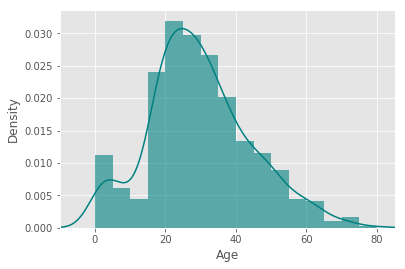

The mean of "Age" is 29.70
The median of "Age" is 28.00


In [7]:
ax = train_df["Age"].hist(bins = np.arange(0, 85, 5), density = True, stacked = True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

Ponieważ rozkład "Age" jest prawoskośny, użycie średniej może dać nam stronnicze wyniki, wypełniając Age starsze niż pożądane. Aby poradzić sobie z tym, użyjemy mediany do przypisania brakujących wartości. Zwróćmy uwagę także, że możemy wydzielić dwie grupy wśród naszej społeczności - dzieci (osoby poniżej 16 roku życia) oraz dorosłych.

##### Cabin

In [8]:
# percent of missing "Cabin" 
print((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100)

77.1043771044


Ponieważ brakuje większości danych w kolumnie 'Cabin', to pominiemy ją podczas tworzenia naszego modelu.

##### Embarked

In [9]:
# percent of missing "Embarked" 
print((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100)

0.224466891134


Ponieważ dla kolumny "Embarked" brakuje wartości tylko w dwóch rekordach danych, to w tym wypadku uzupełnimy je przez najczęściej występujących w danych port. Sprawdźmy zatem, z którego portu najczęściej odpływali ludzie.

S    644
C    168
Q     77
Name: Embarked, dtype: int64


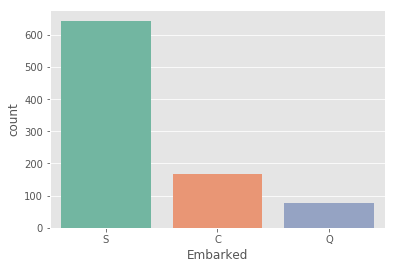

In [10]:
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

Z wykresu oraz tabelki danych widzimy, że najpopularniejszym portem był Southampton.

### Uzupełnianie danych

Na podstawie powyższej analizy w następujący sposób uzupełnimy nasze dane:

- Jeśli w danym wierszu brakuje wartości w kolumnie "Age", to przypiszemy mu wartość 28 (średni wiek).
- Jeśli w danym wierszu brakuje wartości w kolumnie "Embarked", to przypiszemy mu wartość "S" (najczęstszy port wejścia na pokład).
- Zignorujemy kolumnę "Cabin". Brakuje w niej zbyt wiele wartości, aby ta kolumna pozwoliła nam uzyskać dodatkowe informacje do modelu. W oparciu o dostępną wiedzę, okazuje się, że wartość ta jest związana z klasą pasażera i zapłaconą taryfą.

In [15]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna = True), inplace = True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace = True)
train_data.drop('Cabin', axis = 1, inplace = True)

In [16]:
# Sprawdzamy, czy usunęliśmy wszystkie brakujące wartości w danych
train_data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

### Data Engineering

Według dokumentacji załączonej na Kaggle kolumna 'SibSp' oraz 'Parch' odnoszą się do podróżowania z rodziną. Dla uproszczenia naszej analizy połączymy wpływ tych zmiennych w jedną zmienną kategoryczną 'TravelAlone', która będzie oznaczać czy dana osoba podróżuje samotnie. Ponadto zauważyliśmy w trakcie eksploracji danych, że społeczność znajdująca się na statku może zostać podzielona na dwie grupy - dzieci, dorośli. W celu uwzględnienia tego podziału stworzymy zmienną IsMinor, która będzie oznaczać czy dana osoba ma mniej niż 16 lat.

In [17]:
# Tworzenie zmiennej kategorycznej dla osób, które podróżują same
train_data['TravelAlone'] = np.where((train_data["SibSp"]+train_data["Parch"])== 0, 1, 0) #Warunek, True, False
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

train_data['IsMinor'] = np.where(train_data['Age'] <= 16, 1, 0)

In [18]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,TravelAlone,IsMinor
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0,0
5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1,0


### Data Preprocessing

Algorytmy uczenia maszynowego są zaprogramowane w ten sposób, że jako wejście przyjmują jedynie macierze danych w postaci liczb. Ponieważ nasze dane zawierają kolumny, które nie zawierają danych numerycznych, to musimy zmienić sposób ich reprezentacji na numeryczny. Aby dokonać tej zamiany poznamy dwie metody: Label Encoding oraz One Hot Encoding, a następnie wykorzystując jedną z nich.

####  Label Encoding vs One Hot Encoding

![LB vs OHE](LabelVSOneHot.jpg)

In [20]:
# One Hot Encoding
training = pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"], drop_first = True)
# Usuwanie zbędnych kolumn
training.drop(['Name', 'Ticket'], axis = 1, inplace = True)

final_train = training
final_train.head()

,Survived,Age,Fare,TravelAlone,IsMinor,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
PassengerId,,,,,,,,,,
1,0,22.0,7.2500,0,0,0,1,0,1,1
2,1,38.0,71.2833,0,0,0,0,0,0,0
3,1,26.0,7.9250,1,0,0,1,0,1,0
4,1,35.0,53.1000,0,0,0,0,0,1,0
5,0,35.0,8.0500,1,0,0,1,0,1,1


Teraz zastosujemy te same zmiany w danych testowych. Dla wieku przypiszemy średnią równą 28. Zignorujemy Kabinę. Dla zmiennej "Emabrked" nic nie musimy robić.

In [21]:
test_df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [41]:
test_data = test_df.copy()

#Uzupełnianie danych
test_data["Age"].fillna(train_df["Age"].median(skipna = True), inplace = True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna = True), inplace = True)
test_data.drop('Cabin', axis = 1, inplace = True)

#Tworzenie nowych zmiennych
test_data['TravelAlone'] = np.where((test_data["SibSp"] + test_data["Parch"])== 0, 1, 0)
test_data['IsMinor']  =np.where(test_data['Age'] <= 16, 1, 0)

#Usuwanie niepotrzebnych zmiennych
test_data.drop(['SibSp', 'Parch', 'Name', 'Ticket'], axis = 1, inplace = True)

#OneHotEncoding
testing = pd.get_dummies(test_data, columns = ["Pclass","Embarked","Sex"], drop_first = True)

final_test = testing
final_test.head()

,Age,Fare,TravelAlone,IsMinor,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
PassengerId,,,,,,,,,
892,34.5,7.8292,1,0,0,1,1,0,1
893,47.0,7.0000,0,0,0,1,0,1,0
894,62.0,9.6875,1,0,1,0,1,0,1
895,27.0,8.6625,1,0,0,1,0,1,1
896,22.0,12.2875,0,0,0,1,0,1,0


Mając przygotowane dane przystępujemy do części uczenia naszego modelu, którym w tym wypadku będzie regresja logistyczna.

## Feature selection

Biorąc pod uwagę zewnętrzny estymator, który przypisuje wagi do funkcji, rekursywna eliminacja cech (RFE) polega na wybieraniu cech poprzez rekurencyjne uwzględnianie coraz mniejszych zestawów cech. Po pierwsze, estymator jest przeszkolony w zakresie początkowego zestawu funkcji, a ważność każdej cechy jest uzyskiwana za pomocą atrybutu coef_ lub atrybutu feature_importances_. Następnie, najmniej ważne funkcje są przycinane z bieżącego zestawu funkcji. Ta procedura jest powtarzana rekursywnie na oczyszczonym zestawie, aż ostatecznie osiągnięta zostanie wymagana liczba funkcji do wybrania.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

cols = ["Age","Fare","TravelAlone","Pclass_1","Pclass_2","Embarked_C","Embarked_S","Sex_male","IsMinor"] 
X = final_train[cols]
y = final_train['Survived']
# Build a logreg and compute the feature importances
model = LogisticRegression()
# create the RFE model and select 8 attributes
rfe = RFE(model, 8)
rfe = rfe.fit(X, y)
# summarize the selection of the attributes
print('Selected features: %s' % list(X.columns[rfe.support_]))

KeyError: "['Pclass_1' 'Embarked_C'] not in index"

RFECV wykonuje RFE w pętli sprawdzania krzyżowego, aby znaleźć optymalną liczbę lub najlepszą liczbę funkcji. Odtąd rekurencyjna eliminacja cech stosowana w regresji logistycznej z automatycznym dostosowaniem liczby funkcji wybranych za pomocą sprawdzania krzyżowego.

In [ ]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Jak widzimy, zachowano osiem zmiennych.

In [ ]:
Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_S', 'Sex_male', 'IsMinor']
X = final_train[Selected_features]

plt.subplots(figsize=(8, 5))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

## Logistic Regression

![Logistic Regression](Logistic1.PNG)

![Logistic Regression](Logistic2.PNG)

![Logistic Regression](Logistic3.PNG)

![Logistic Regression](Logistic4.PNG)

![Logistic Regression](Logistic5.PNG)

![Logistic Regression](Logistic6.PNG)

![Logistic Regression](Logistic7.PNG)

![Logistic Regression](Logistic8.PNG)

In [32]:
final_train.head()

,Survived,Age,Fare,TravelAlone,IsMinor,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male
PassengerId,,,,,,,,,,
1,0,22.0,7.2500,0,0,0,1,0,1,1
2,1,38.0,71.2833,0,0,0,0,0,0,0
3,1,26.0,7.9250,1,0,0,1,0,1,0
4,1,35.0,53.1000,0,0,0,0,0,1,0
5,0,35.0,8.0500,1,0,0,1,0,1,1


In [33]:
#Podział danych na dane testowe oraz treningowe
from sklearn.model_selection import train_test_split

X = final_train.drop('Survived', axis = 1)
y = final_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.794776119403


##### Confusion Matrix

![Confusion Matrix](ConfMatrix.png)

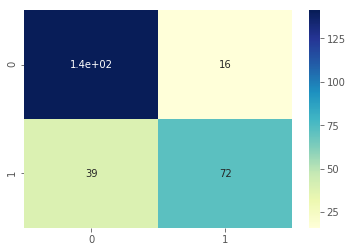

In [36]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = "YlGnBu")
plt.show()

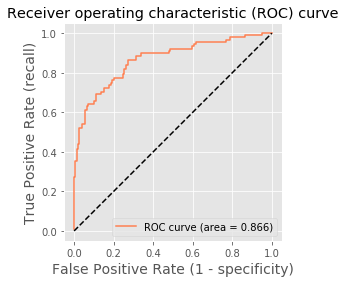

In [37]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color = 'coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.axis('square')
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc = "lower right")
plt.show()

In [38]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('AUC: ', auc(fpr, tpr))

Accuracy:  0.809701492537
AUC:  0.866471567109


In [47]:
y_pred = logreg.predict(final_test)

submission = pd.DataFrame({
        "PassengerId": final_test.index,
        "Survived": y_pred
    })
submission.to_csv('submission.csv', index = False)

Source: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python/notebook